In [17]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import pandas as pd
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


In [18]:
# Initialize the Qiskit runtime service with your IBM Quantum API token
service = QiskitRuntimeService()

# Select a backend with the fewest number of jobs in the queue
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
print(f"Using backend: {backend.name}")

# Create an angle parameter
theta = Parameter("$\\theta$")
# Create a quantum circuit with 2 qubits
qc = QuantumCircuit(2)

# Create an entangled pair of qubits
qc.h(0)
qc.cx(0, 1)
# Rotation gate on the 1st qubit
qc.ry(theta, 0)

number_of_phases = 21  # number of angles for which we will test
phases = np.linspace(0, 2 * np.pi, number_of_phases)
individual_phases = [[ph] for ph in phases]

# Mapping the CHSH Formula to the Pauli Operators (Pauli operators will represent the observables <__>)
observable1 = SparsePauliOp.from_list([("ZZ", 1), ("ZX", -1), ("XZ", 1), ("XX", 1)])
observable2 = SparsePauliOp.from_list([("ZZ", 1), ("ZX", 1), ("XZ", -1), ("XX", 1)])

# Create the preset pass manager for optimization
pm = generate_preset_pass_manager(target=backend.target, optimization_level=3)
qc_isa_circuit = pm.run(qc)

# Transform the observables to make them backend compatible before running jobs with Estimator
isa_observable1 = observable1.apply_layout(layout=qc_isa_circuit.layout)
isa_observable2 = observable2.apply_layout(layout=qc_isa_circuit.layout)

# Define individual observables for each part of the CHSH equation 
observable_AB = (isa_observable1[0])
observable_minus_Ab = (isa_observable1[1])
observable_aB = (isa_observable1[2])
observable_ab = (isa_observable1[3])
observable_Ab = (isa_observable2[1])
observable_minus_aB = (isa_observable2[2])


Using backend: ibm_sherbrooke


In [19]:
# Initialize the estimator with the real backend
estimator = Estimator(mode=backend)

# Run the jobs and get the result
job_result = estimator.run([(qc_isa_circuit, [[observable_AB], [observable_minus_Ab], [observable_aB], [observable_ab], [observable_Ab], [observable_minus_aB]], phases)]).result()

# Access the individual expectation values
AB = job_result[0].data.evs[0]
minus_Ab = job_result[0].data.evs[1] 
aB = job_result[0].data.evs[2]
ab = job_result[0].data.evs[3]
Ab = job_result[0].data.evs[4]
minus_aB = job_result[0].data.evs[5]

# Get S values 
CHSH_1 = AB + minus_Ab + aB + ab
CHSH_2 = AB + Ab + minus_aB + ab



In [20]:
# Make a table for expectation values
expected_1 = np.round(AB, 3)
expected_2 = np.round(Ab, 3)
expected_3 = np.round(aB, 3)
expected_4 = np.round(ab, 3)

# Combine expected values into a 2D array
data = np.array([expected_1, expected_2, expected_3, expected_4])

# Create the DataFrame with expected values as columns and phases as rows
df = pd.DataFrame(data.T, index=[f"Phase {round(angle, 2)}" for angle in phases], columns=['<AB>', '<Ab>', '<aB>', '<ab>'])

# Set Pandas to display 3 decimal places
pd.options.display.float_format = '{:.3f}'.format

# Display the DataFrame
print(df)



             <AB>   <Ab>   <aB>   <ab>
Phase 0.0   0.990  0.046 -0.022  1.010
Phase 0.31  0.943  0.331 -0.338  0.950
Phase 0.63  0.826  0.604 -0.574  0.796
Phase 0.94  0.581  0.829 -0.827  0.564
Phase 1.26  0.285  0.970 -0.956  0.274
Phase 1.57 -0.034  0.994 -1.007 -0.024
Phase 1.88 -0.311  0.945 -0.952 -0.369
Phase 2.2  -0.592  0.781 -0.804 -0.631
Phase 2.51 -0.809  0.551 -0.592 -0.858
Phase 2.83 -0.958  0.282 -0.295 -0.962
Phase 3.14 -0.997 -0.053  0.033 -1.000
Phase 3.46 -0.953 -0.320  0.326 -0.939
Phase 3.77 -0.790 -0.608  0.583 -0.803
Phase 4.08 -0.552 -0.821  0.834 -0.562
Phase 4.4  -0.286 -0.960  0.959 -0.282
Phase 4.71 -0.014 -0.994  1.010  0.012
Phase 5.03  0.336 -0.936  0.946  0.333
Phase 5.34  0.577 -0.797  0.806  0.598
Phase 5.65  0.829 -0.570  0.559  0.844
Phase 5.97  0.948 -0.293  0.302  0.975
Phase 6.28  1.006  0.027 -0.018  0.993


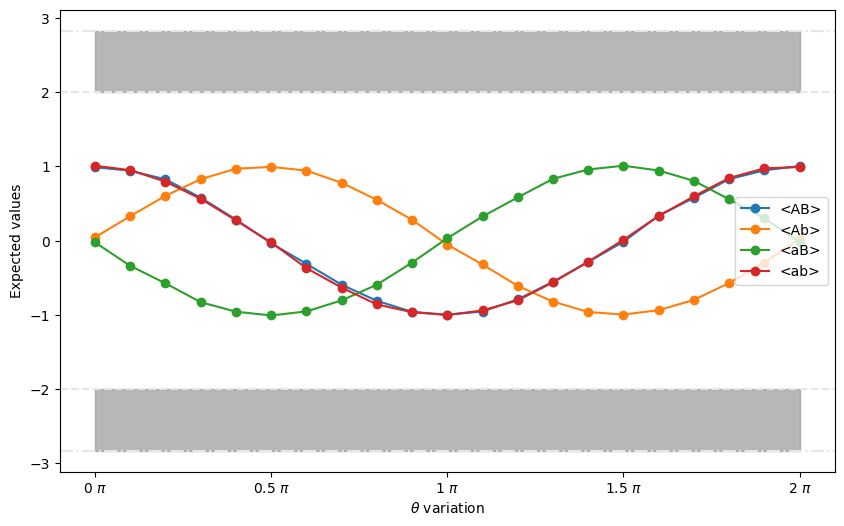

In [21]:
# Graph Expected values vs angle variation
fig, ax = plt.subplots(figsize=(10, 6))

# results from hardware
ax.plot(phases / np.pi, AB, "o-", label="<AB>", zorder=3)
ax.plot(phases / np.pi, Ab, "o-", label="<Ab>", zorder=3)
ax.plot(phases / np.pi, aB, "o-", label="<aB>", zorder=3)
ax.plot(phases / np.pi, ab, "o-", label="<ab>", zorder=3)

# classical bound +-2
ax.axhline(y=2, color="0.9", linestyle="--")
ax.axhline(y=-2, color="0.9", linestyle="--")

# quantum bound, +-2√2
ax.axhline(y=np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.axhline(y=-np.sqrt(2) * 2, color="0.9", linestyle="-.");

# Plot details
ax.fill_between(phases / np.pi, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7)
ax.fill_between(phases / np.pi, -2, -2 * np.sqrt(2), color="0.6", alpha=0.7)
ax.xaxis.set_major_formatter(tck.FormatStrFormatter("%g $\\pi$"))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5))

plt.xlabel("$\\theta$ variation")
plt.ylabel("Expected values")
plt.legend()
plt.show()



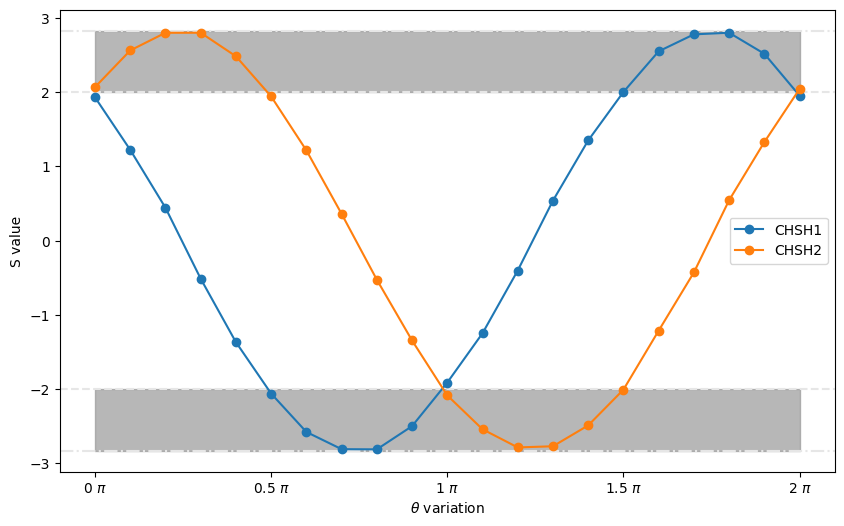

In [22]:
# Graph S vs. angle variation
fig, ax = plt.subplots(figsize=(10, 6))

# results from hardware
ax.plot(phases / np.pi, CHSH_1, "o-", label="CHSH1", zorder=3)
ax.plot(phases / np.pi, CHSH_2, "o-", label="CHSH2", zorder=3)

# classical bound +-2
ax.axhline(y=2, color="0.9", linestyle="--")
ax.axhline(y=-2, color="0.9", linestyle="--")

# quantum bound, +-2√2
ax.axhline(y=np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.axhline(y=-np.sqrt(2) * 2, color="0.9", linestyle="-.");
ax.fill_between(phases / np.pi, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7)
ax.fill_between(phases / np.pi, -2, -2 * np.sqrt(2), color="0.6", alpha=0.7)

# Plot details 
ax.xaxis.set_major_formatter(tck.FormatStrFormatter("%g $\\pi$"))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5))

plt.xlabel("$\\theta$ variation")
plt.ylabel("S value")
plt.legend()
plt.show()